In [111]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline
import glob, os
import seaborn as sns
import sys
from sklearn.preprocessing import MinMaxScaler

appl_data = pd.read_csv("./AAPL.csv")
print(appl_data.head())
print(appl_data.info())
columns = appl_data.columns
columns


         Date      Open      High       Low     Close  Adj Close     Volume
0  2000-05-22  3.348214  3.348214  3.071429  3.212054   2.133590  188876800
1  2000-05-23  3.232143  3.334821  3.058036  3.064732   2.035733  129396400
2  2000-05-24  3.078125  3.205357  2.964286  3.131696   2.080215  169615600
3  2000-05-25  3.160714  3.309150  3.071429  3.116629   2.070205  101687600
4  2000-05-26  3.142857  3.209821  3.044643  3.084821   2.049076   45287200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4778 entries, 0 to 4777
Data columns (total 7 columns):
Date         4778 non-null object
Open         4778 non-null float64
High         4778 non-null float64
Low          4778 non-null float64
Close        4778 non-null float64
Adj Close    4778 non-null float64
Volume       4778 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 261.4+ KB
None


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

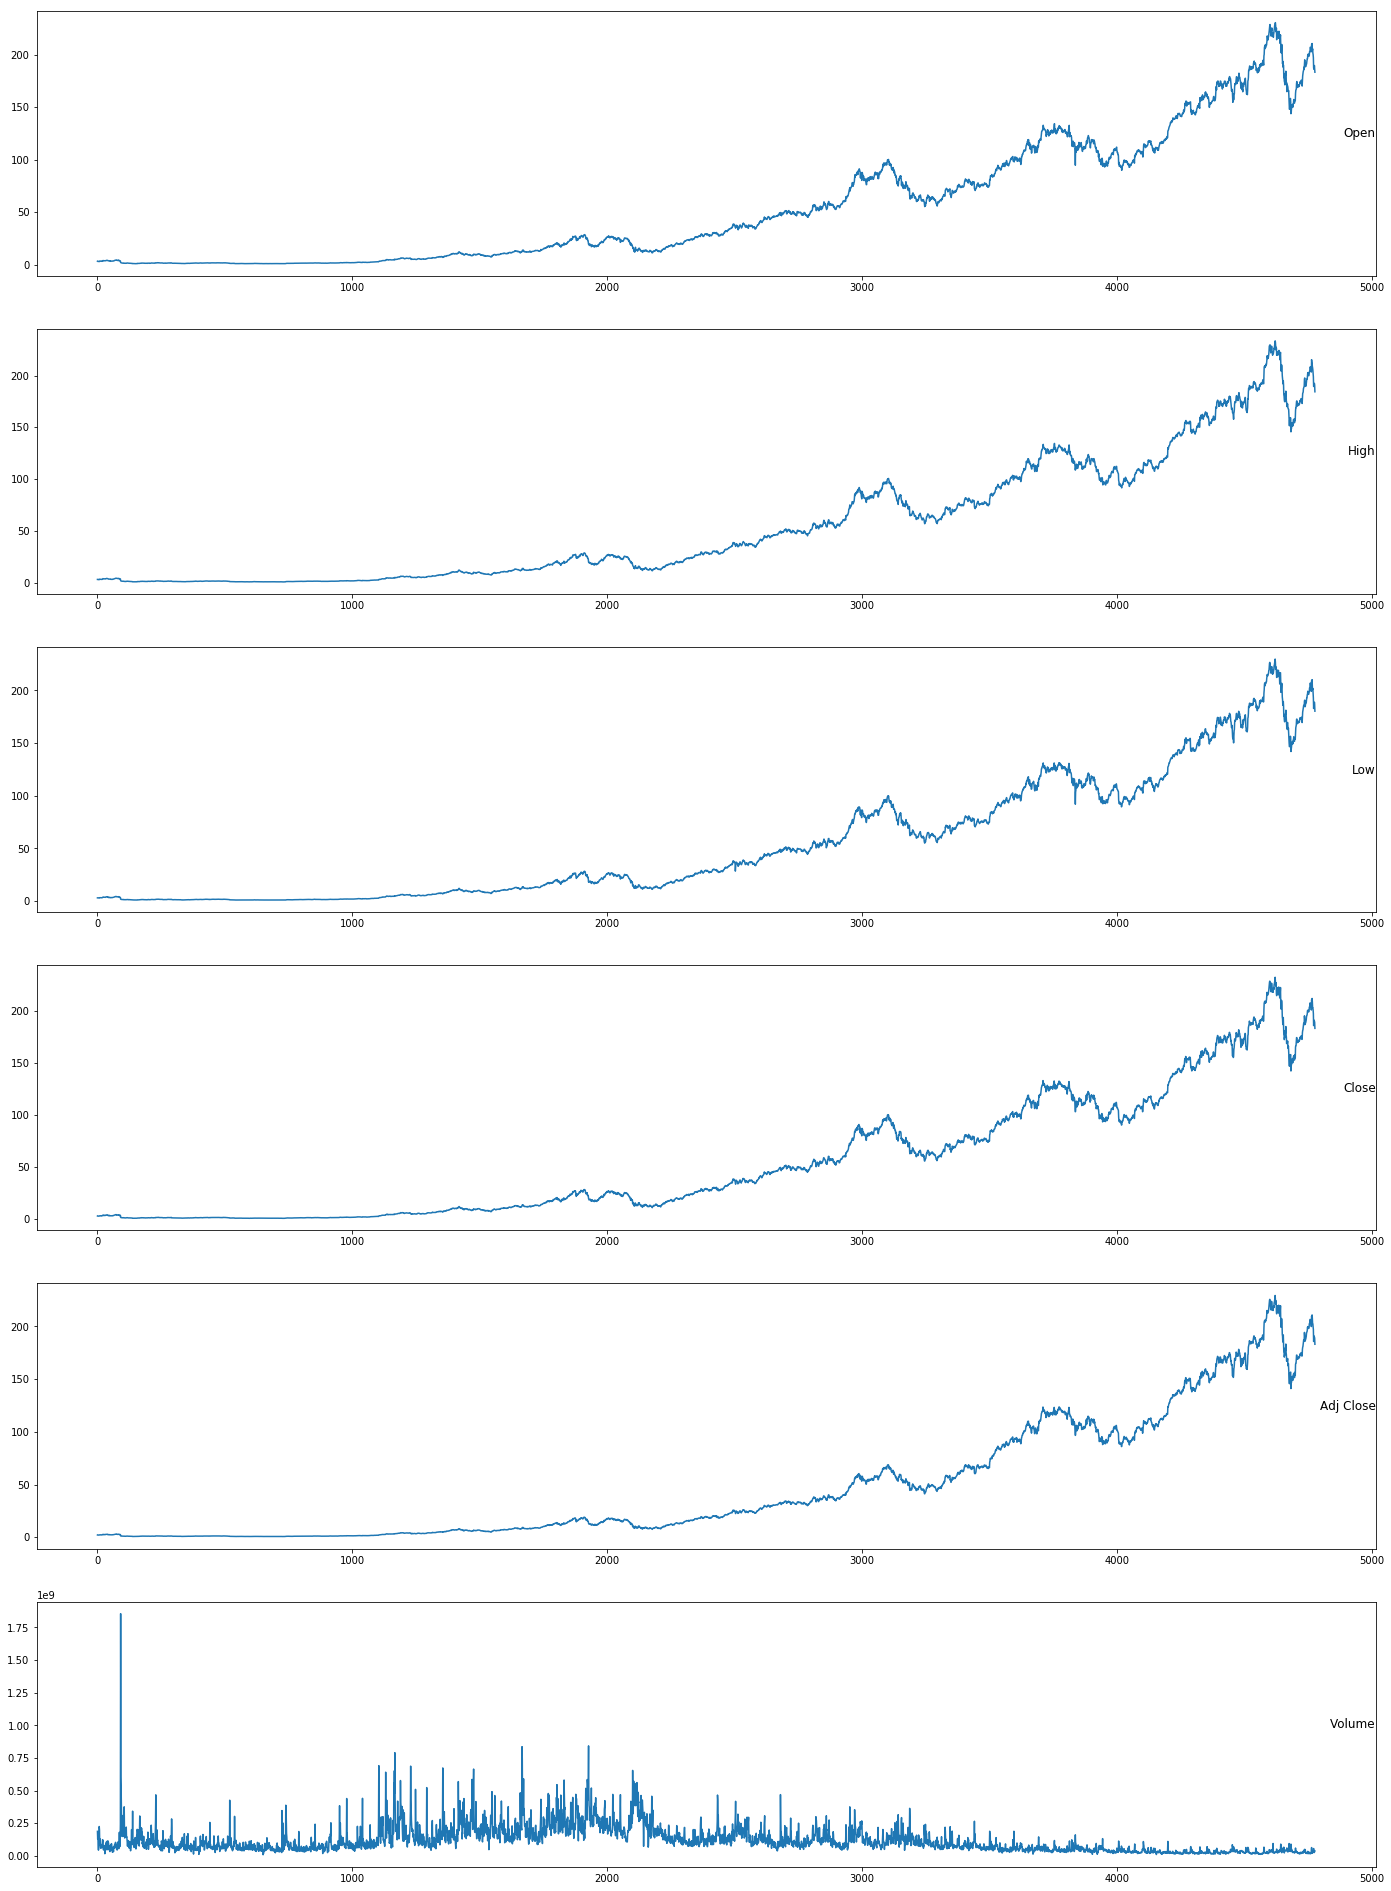

In [112]:
plt.figure(figsize=(24,40))
for i in range(1,7):
    plt.subplot(7, 1, i+1)
    plt.plot(appl_data.values[:, i])
    plt.title(columns[i], y=0.5, loc='right')
    
plt.show()

In [113]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [114]:
scaler = MinMaxScaler(feature_range=(0,1))
values = appl_data[['Open','Volume','High','Low','Close','Adj Close']].values
values = values.astype('float32')
scale_data = scaler.fit_transform(values)
# print(scale_data)
redf = series_to_supervised(scale_data, 1, 1)
# print(redf)
redf.drop(redf.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(redf)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.010530   0.097011   0.010347   0.009450   0.009842   0.006605   
2      0.010025   0.064783   0.010290   0.009392   0.009205   0.006178   
3      0.009355   0.086575   0.009733   0.008982   0.009495   0.006372   
4      0.009714   0.049769   0.010179   0.009450   0.009430   0.006328   
5      0.009637   0.019209   0.009752   0.009333   0.009292   0.006236   
6      0.009578   0.091261   0.009483   0.008787   0.009475   0.006359   
7      0.009462   0.053394   0.009963   0.009109   0.008925   0.005990   
8      0.008666   0.117104   0.009704   0.008572   0.009717   0.006521   
9      0.010530   0.102070   0.011269   0.009918   0.010248   0.006878   
10     0.010462   0.038515   0.010578   0.010026   0.010055   0.006748   
11     0.010253   0.065852   0.010808   0.010123   0.010296   0.006910   
12     0.010511   0.040323   0.010847   0.010328   0.010866   0.007292   
13     0.011132   0.026982   0.011077 

In [115]:
train_days = 3000
valid_days = 150
values = redf.values
train = values[:train_days, :]
test = values[train_days:train_days+150, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [116]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3000, 1, 6) (3000,) (150, 1, 6) (150,)


In [117]:
# model2 = Sequential()
# model2.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model2.add(LSTM(units=32))
# model2.add(Dense(units=16))
# model2.add(Dropout(0.2))
# model2.add(Dense(1, activation='relu'))
# model2.compile(loss='mean_squared_error', optimizer='adam')

# print(model2.summary())
print(train_X)
print(train_y)

[[[0.01053006 0.09701139 0.01034745 0.0094501  0.00984244 0.00660533]]

 [[0.01002508 0.06478273 0.01028986 0.00939158 0.00920505 0.00617757]]

 [[0.00935501 0.08657496 0.00973309 0.00898197 0.00949477 0.00637201]]

 ...

 [[0.3635163  0.1343274  0.3612624  0.3520754  0.35008928 0.23494735]]

 [[0.3506074  0.12559624 0.35023454 0.34346172 0.34929815 0.23441644]]

 [[0.34563527 0.14044528 0.34471753 0.34245053 0.34223977 0.22967948]]]
[0.01002508 0.00935501 0.00971432 ... 0.3506074  0.34563527 0.37859434]


In [118]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))

model.add(LSTM(units=64, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(LSTM(units=32))
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# print(model.summary())

# cnn = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = LSTM(64, return_sequences=True)(cnn) # ** 
# cnn = Flatten()(cnn)
# cnn = Dense(50, activation='relu')(cnn)

In [119]:
# LSTM = model2.fit(train_X, train_y, epochs=300, batch_size=32, verbose=2, shuffle=False)
# LSTM = model2.fit(train_X, train_y, epochs = 100, batch_size = 32)
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 3000 samples, validate on 150 samples
Epoch 1/100
 - 5s - loss: 0.0127 - val_loss: 0.0297
Epoch 2/100
 - 1s - loss: 0.0285 - val_loss: 0.0295
Epoch 3/100
 - 1s - loss: 0.0164 - val_loss: 0.0085
Epoch 4/100
 - 1s - loss: 0.0113 - val_loss: 0.0044
Epoch 5/100
 - 1s - loss: 0.0050 - val_loss: 0.0033
Epoch 6/100
 - 1s - loss: 0.0068 - val_loss: 0.0084
Epoch 7/100
 - 1s - loss: 0.0061 - val_loss: 0.0033
Epoch 8/100
 - 1s - loss: 0.0051 - val_loss: 0.0033
Epoch 9/100
 - 1s - loss: 0.0059 - val_loss: 0.0034
Epoch 10/100
 - 1s - loss: 0.0031 - val_loss: 0.0053
Epoch 11/100
 - 1s - loss: 0.0059 - val_loss: 0.0046
Epoch 12/100
 - 1s - loss: 0.0043 - val_loss: 0.0035
Epoch 13/100
 - 1s - loss: 0.0059 - val_loss: 0.0043
Epoch 14/100
 - 1s - loss: 0.0042 - val_loss: 0.0033
Epoch 15/100
 - 1s - loss: 0.0059 - val_loss: 0.0046
Epoch 16/100
 - 1s - loss: 0.0031 - val_loss: 0.0062
Epoch 17/100
 - 1s - loss: 0.0060 - val_loss: 0.0033
Epoch 18/100
 - 1s - loss: 0.0048 - val_loss: 0.0035
Epoch 19

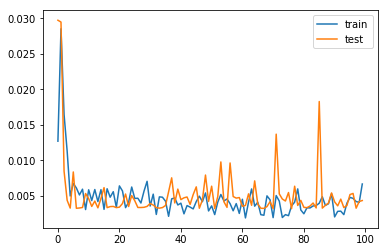

In [120]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

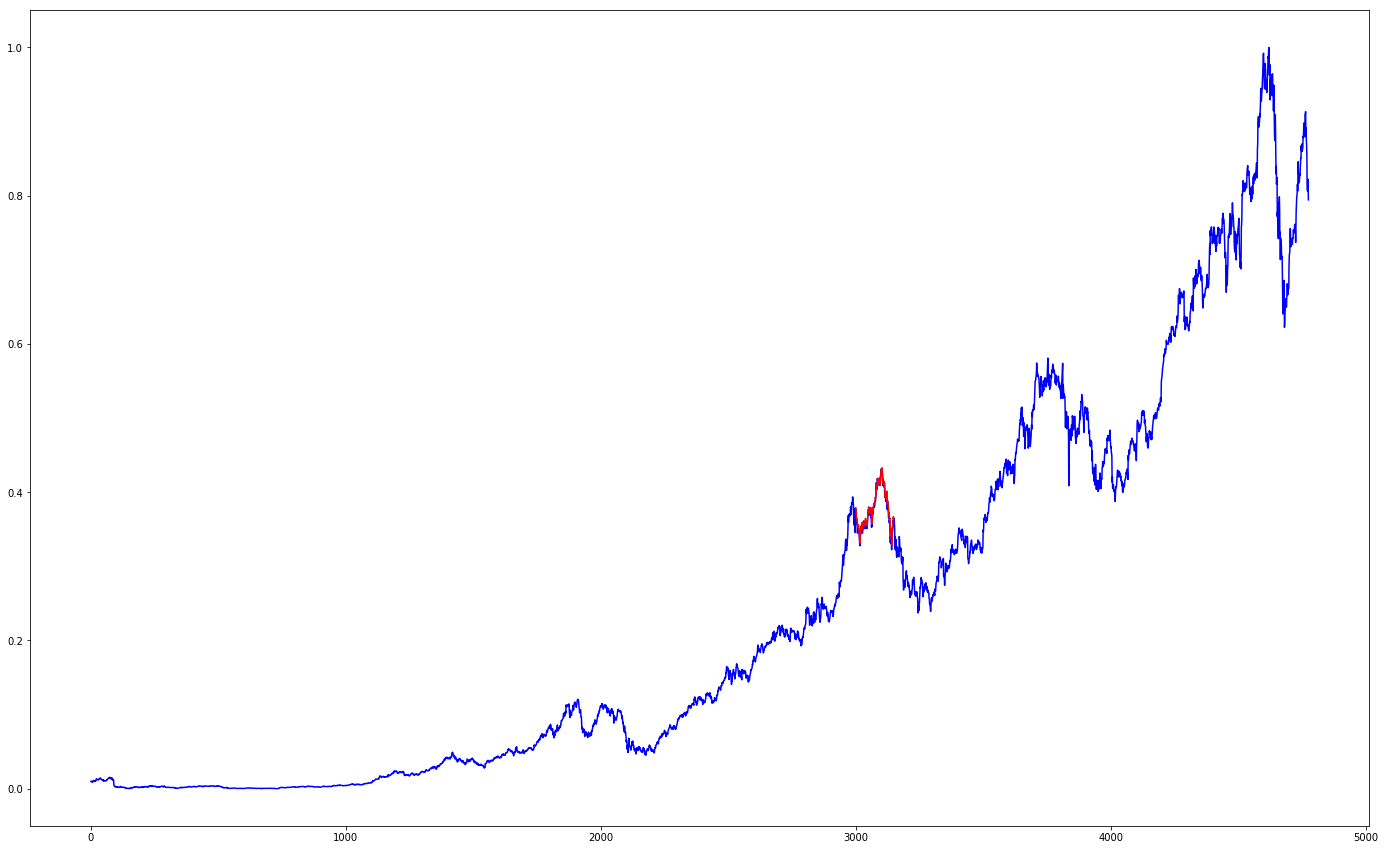

In [122]:
# plt.figure(figsize=(24,8))
# train_predict = model2.predict(train_X)
# valid_predict = model2.predict(valid_X)
# test_predict = model2.predict(test_X)

# plt.plot(values[:, -1], c='b')
# plt.plot([x for x in train_predict], c='g')
# plt.plot([None for _ in train_predict] + [x for x in valid_predict], c='y')
# plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
# plt.show()

plt.figure(figsize=(24,15))

test_predict = model.predict(test_X)

plt.plot(values[:, -1], c='b')
# plt.plot([x for x in train_predict], c='g')
# plt.plot([None for _ in train_predict] + [x for x in valid_predict], c='y')
plt.plot([None for _ in range(train_days)] + [x for x in test_predict], c='r')
plt.show()
